## Composing models

by Ziga Avsec

Composing models means that we take the predictions of some model and use it as input for another model like this:

![img](../docs/theme_dir/img/nbs/comp_models.gv.svg)

Three different scenarios can occur when we want to compose models from Kipoi:

1. all models are written in the same framework (say Keras)
2. models are written in different frameworks but can all be executed in the same python environment
3. models are written in different frameworks and can't be executed in the same python environment due to dependency incompatibilities

## All models in the same framework

In case all models are written in the same framework, you can stitch things together in the framework. Here is an example of how to do this in Keras.

![img](../docs/theme_dir/img/nbs/comp_models3.gv.svg)

Let's first dump 4 dummy models:

In [108]:
import keras.layers as kl
from keras.models import Model
from keras.models import load_model

In [113]:
# create model 1
inp1 = kl.Input((3,), name="input1")
out1 = kl.Dense(4)(inp1)
m1 = Model(inp1, out1)
m1.save("/tmp/m1.h5")

# create model 2
inp2 = kl.Input((7,), name="input1_model1")
out2 = kl.Dense(3)(inp2)
m2 = Model(inp2, out2)
m2.save("/tmp/m2.h5")

# create model 3
inp3 = kl.Input((6,), name="input2")
out3 = kl.Dense(4)(inp3)
m3 = Model(inp3, out3)
m3.save("/tmp/m3.h5")

# create model 4
inp4 = kl.Input((7,), name="model2_model3")
out4 = kl.Dense(1)(inp4)
m4 = Model(inp4, out4)
m4.save("/tmp/m4.h5")

Next, we load the models back:

In [114]:
## Load models
m1 = load_model("/tmp/m1.h5")
m2 = load_model("/tmp/m2.h5")
m3 = load_model("/tmp/m3.h5")
m4 = load_model("/tmp/m4.h5")

/opt/modules/i12g/anaconda/3-5.0.1/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


And compose them

In [115]:
m2_in = kl.concatenate([m1.output, m1.input])
m2_out = m2(m2_in)

m3_in = kl.concatenate([m2_out, m3.output])
out = m4(m3_in)

m = Model(inputs=[m1.input, m3.input], outputs=out)

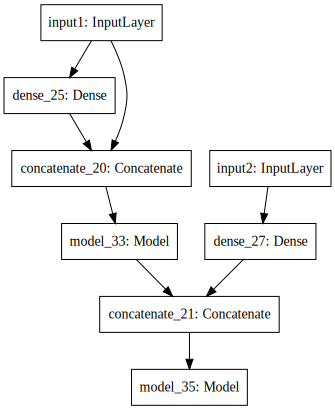

In [116]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

svg_img = model_to_dot(m, ).create(prog='dot', format='svg')
SVG(svg_img)

Now we could go ahead, merge the dataloaders from model1 and model3 into a single one (providing input1 and input2) and train this global network for a new task. In case we would like to freeze supparts of the network, we should 'freeze' the underlying models by setting `m1.trainable = False`.

### Contributing to Kipoi

To contribute such model to Kipoi, we would need to submit the merged dataloader (providing input1 and input2 from raw files) and dump the stitched Keras model. 

## Models in different frameworks

There are two scenarios when composing models from different frameworks. Either their dependencies (dataloader, etc) are compatible (say a tensorflow and a keras model) or they are incompatible (one model uses `keras=0.3` and and another one `keras=2.0`).

### Compatible dependencies

To compose compatible models, we pack the majority of the models into the dataloader and then have the final ensembling model stored as the model.

![img](../docs/theme_dir/img/nbs/comp_models2.gv.svg)

In [129]:
def new_dataloader(dl1_kwargs, dl2_kwargs, target_file, batch_size=32, num_workers=1):
    m1 = kipoi.get_model("model1")
    m2 = kipoi.get_model("model2")
    m3 = kipoi.get_model("model3")
    
    dl1 = m1.default_dataloader(**dl1_kwargs)
    dl2 = m1.default_dataloader(**dl2_kwargs)
    
    target_gen = get_target_gen(target_file)
    
    batch_it1 = dl1.batch_iter(batch_size=batch_size, num_workers=num_workers)
    batch_it2 = dl2.batch_iter(batch_size=batch_size, num_workers=num_workers)
    
    while True:
        batch1 = next(batch_it1)['inputs']
        batch2 = next(batch_it2)['inputs']
        targets, ids = next(target_gen)
        
        m1_pred = m1.predict_on_batch(batch1)
        m2_pred = m2.predict_on_batch(np.concatenate((batch1, m1_pred), axis=1))
        m3_pred = m3.predict_on_batch(batch2)
        yield {"inputs": {"model2": m2_pred, "model3": m3_pred}, 
               "targets": targets, 
               "metadata": {"model1_id": batch1["metadata"]["id"],
                            "model3_id": batch2["metadata"]["id"],
                            "targets_id": ids,
                           }
              }

In [127]:
# create model 4
inp2 = kl.Input((3,), name="model2")
inp3 = kl.Input((4,), name="model3")
x = kl.concatenate([inp2, inp3])
out4 = kl.Dense(1)(x)
m4 = Model([inp2, inp3], out4)
m4.compile('rmsprop',
           loss='categorical_crossentropy',
           metrics=['accuracy'])

In [130]:
# Train model4
def create_train_gen(**kwargs):
    while True:
        gen = new_dataloader(**kwargs)
        while True:
            batch = next(gen)
            yield (batch['inputs'], batch['targets'])
            
train_gen = create_train_gen(...)            
m4.fit_generator(train_gen, ...)

In [ ]:
# Dump model4
m4.save("model_files/model.h5")

### Incompatible dependencies

Sometimes, making a prediction for all the models in the same python environment might be difficult or impossible due to the incompatible dependencies. 

In that case, we should run the prediction of each model in a separate environment and save the predictions to the disk.

Luckily, there exist many Make-like tools that can support this kind of a workflow. My favorite is Snakemake <http://snakemake.readthedocs.io/>. I'll show you how to do this in snakemake.

Let's consider the following case:

![img](../docs/theme_dir/img/nbs/comp_models4.gv.svg)

In [162]:
# Python part of the Snakefile
import os
import subprocess
py_path = subprocess.check_output(['which', 'python']).decode().strip()
env_paths = os.path.join(os.path.dirname(py_path), "../envs")

def get_args(wildcards):
    """Function returning a dictionary of dataloader kwargs
    for the corresponding model
    """
    if wildcards.model == "model3":
        return {"arg1": 1}
    elif wildcards.model == "model3":
        return {""}
    else:
        return {"arg2": 1}

```yaml
# Yaml part of the Snakefile
rule all:
  inputs: expand("predictions/{model}.h5", ["model1", "model2"])

rule create_evironment:
  """Create a new conda environment for each model"""
  output: os.path.join(env_paths, "kipoi-{model}", "bin/kipoi")
  shell: "kipoi env create {wildcards.model} -e kipoi-{wildcards.model}"

rule run_predictions:
  """Create a new conda environment for each model"""
  input: os.path.join(env_paths, "kipoi-{model}", "bin/kipoi")
  output: "predictions/{model}.h5"
  params:
    dl_args: get_args
    batch_size: 15
  threads: 8
  shell: 
      """
      source activate kipoi-{wildcards.model}
      kipoi predict {wildcards.model} \
        -n {threads} \
        --dataloader_args='{params.dl_args}' \
        --batch_size={params.batch_size} \
        -f hdf5 \
        -o {output} 
      """
```

This snakefile will generate the following hdf5 files

- `predictions/model1.h5`
- `predictions/model2.h5`

To combine them, let's write new dataloader, taking as input the hdf5 files containing predictions

In [171]:
import deepdish


def new_dataloader(model1_h5, model2_h5, target_file):
    d1 = deepdish.io.load(model1_h5)
    d2 = deepdish.io.load(model2_h5)
    targets = load_target_file(target_file)
    return {
        "inputs": {
            "model1": d1["predictions"],
            "model2": d2["predictions"],
        },
        "targets": targets,
        "metadata": {
            "model1_id": d1["metdata"]["id"],
            "model2_id": d2["metdata"]["id"],
        }
    }

In [ ]:
# get the training data ...
data_train = new_dataloader("predictions/model1.h5"
                            "predictions/model1.h5",
                            "target_file.h5")

In [ ]:
# train the model...
m4.fit(data_train['inputs'], data_train['targets'])

In [ ]:
# Dump the model
m4.save("model_files/model.h5")

## Uploading composite models to Kipoi

Since every Kipoi model pipeline consists of a single dataloader and a single model, we have to pack multiple models either into a single model or a single dataloader. Here is the recommendation how to do so:

- All models in the same framework
    - **Dataloader:** newly written, combines dataloaders
    - **Model:** combines models by stitching them together in the framework
- Different frameworks, compatible dependencies
    - **Dataloader:** newly written, combines dataloaders and models
    - **Model:** final ensembling model (model 4)
- Different frameworks, in-compatible dependencies
    - **Dataloader:** newly written, loads data from the hdf5 files containing model predictions
    - **Model:** final ensembling model (model 4)